# Francisco Alfredo Castrellon Carrillo
# David Gamaliel Arcos Bravo

In [2]:
import imp
import sys
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  
import seaborn as sb
import cv2
from collections import defaultdict, deque
from scipy import ndimage as ndi

from copy import deepcopy
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import NearestNeighbors
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
import numba
from numba import jit, cuda

import warnings
#warnings.filterwarnings("ignore")

with warnings.catch_warnings():
    warnings.simplefilter('ignore', numba.errors.NumbaDeprecationWarning)

In [3]:
@jit(target_backend='cuda')
def erosion(img, estructure, n=1):
    w, h = estructure.shape
    wArr = list(range(-(int(w/2)), (int(w/2))+1))
    hArr = list(range(-(int(h/2)), (int(h/2))+1))
    for ciclos in range(n):
        imgR = np.zeros(img.shape, dtype=np.int64)
        for i in range(len(img)):
            for j in range(len(img[i])):
                if img[i][j] == 255:
                    b = True
                    for x in wArr:
                        for y in hArr:
                            if (0 <= i+y < len(img) and 0 <= j+x < len(img[i])):
                                if estructure[y+int(h/2)][x+int(w/2)] == 1 and img[i+y][j+x] == 0:
                                    b = False
                    imgR[i][j] = 255 if b else 0
        img = imgR
    return img

@jit(target_backend='cuda')
def dilatation(img, estructure, n=1):
    w, h = estructure.shape
    wArr = list(range(-(int(w/2)), (int(w/2))+1))
    hArr = list(range(-(int(h/2)), (int(h/2))+1))
    for ciclos in range(n):
        imgR = np.zeros(img.shape, dtype=np.int64)
        for i in range(len(img)):
            for j in range(len(img[i])):
                if img[i][j] == 255:
                    for x in wArr:
                        for y in hArr:
                            if (0 <= i+y < len(img) and 0 <= j+x < len(img[i])):
                                if estructure[y+int(h/2)][x+int(w/2)] == 1:
                                    imgR[i+y][j+x] = 255
        img = imgR
    return img

@jit(target_backend='cuda')
def morphOpen(img, estructure, depth=1, loops=1):
    for i in range(loops):
        img = erosion(img, estructure, depth)
        img = dilatation(img, estructure, depth)
    return img

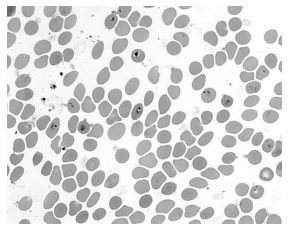

In [4]:
#img = cv2.imread('../Datasets/bloodCells.jpg', cv2.IMREAD_COLOR)
#img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.imread('../Datasets/bloodCells.jpg', cv2.IMREAD_GRAYSCALE)
img = np.array(img, dtype=np.int64)
plt.axis("off")
plt.imshow(img, cmap="gray")

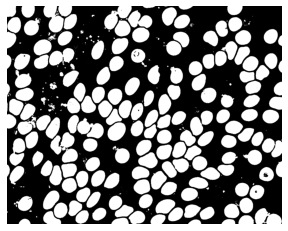

In [5]:
binImg = np.zeros(img.shape, dtype=np.int64)
binImg[img < 220] = 255
plt.axis("off")
plt.imshow(img, cmap="gray")
plt.imshow(binImg, cmap="gray")

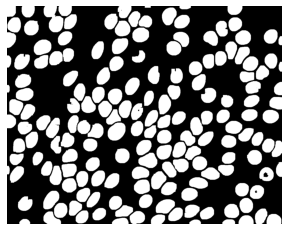

In [16]:
estructure = np.array([[1,1,1,1,1], 
                       [1,1,1,1,1], 
                       [1,1,1,1,1], 
                       [1,1,1,1,1], 
                       [1,1,1,1,1]])
resImg = morphOpen(binImg, estructure, depth=4, loops=1)
plt.axis("off")
plt.imshow(resImg, cmap="gray")

In [7]:

def countCells(img):
    imgCounted = np.zeros(img.shape, dtype=np.int64)
    h, w = img.shape
    queue = deque()
    counts = 0
    for row in range(len(img)):
        for col in range(len(img[row])):
            if img[row][col] and not imgCounted[row][col]:
                queue.append((row, col))
                counts += 1
                while len(queue) > 0:
                    y, x = queue.pop()
                    imgCounted[y][x] = 1
                    if y-1 >= 0: 
                        if img[y-1][x] and not imgCounted[y-1][x]:
                            queue.append((y-1, x))
                    if y+1 < h: 
                        if img[y+1][x] and not imgCounted[y+1][x]:
                            queue.append((y+1, x))
                    if x-1 >= 0: 
                        if img[y][x-1] and not imgCounted[y][x-1]:
                            queue.append((y, x-1))
                    if x+1 < w: 
                        if img[y][x+1] and not imgCounted[y][x+1]:
                            queue.append((y, x+1))
    return counts

In [8]:
countCells(resImg)

172

In [10]:
estructure = np.array([[1,1,1,1,1], 
                       [1,1,1,1,1], 
                       [1,1,1,1,1], 
                       [1,1,1,1,1], 
                       [1,1,1,1,1]])
for i in range(8):
    resImg = morphOpen(binImg, estructure, depth=i, loops=1)
    print(f"Depth: {i}, Count: {countCells(resImg)}")

Depth: 0, Count: 591
Depth: 1, Count: 218
Depth: 2, Count: 178
Depth: 3, Count: 174
Depth: 4, Count: 172
Depth: 5, Count: 172
Depth: 6, Count: 171
Depth: 7, Count: 168
